## Part I: Preprocessing and EDA

- The data comes from a global e-retailer company, including orders from 2012 to 2015. Import the **Orders** dataset and do some basic EDA. 
- For problem 1 to 3, we mainly focus on data cleaning and data visualizations. You can use all the packages that you are familiar with to conduct some plots and also provide **brief interpretations** about your findings.

### Problem 1: Dataset Import & Cleaning
Check **"Profit"** and **"Sales"** in the dataset, convert these two columns to numeric type. 

In [1]:
import pandas as pd
orders = pd.read_csv('../data/Orders.csv', index_col=0, parse_dates=True)

In [2]:
orders['Profit'] = pd.to_numeric(orders['Profit'].str.replace('$', '').str.replace(',',''))
orders['Sales'] = pd.to_numeric(orders['Sales'].str.replace('$', '').str.replace(',',''))

### Problem 2: Inventory Management
- Retailers that depend on seasonal shoppers have a particularly challenging job when it comes to inventory management. Your manager is making plans for next year's inventory.
- He wants you to answer the following questions:
    1. Is there any seasonal trend of inventory in the company?
    2. Is the seasonal trend the same for different categories?

- ***Hint:*** For each order, it has an attribute called `Quantity` that indicates the number of product in the order. If an order contains more than one product, there will be multiple observations of the same order.

In [3]:
orders['Order.Date'] = pd.to_datetime(orders['Order.Date'])
orders = orders.set_index(orders['Order.Date'])

bins = [0, 91, 183, 275, 366]
labels=['Winter', 'Spring', 'Summer', 'Fall']
doy = orders.index.dayofyear
orders['Season'] = pd.cut(doy + 11 - 366*(doy > 355), bins=bins, labels=labels)

season_trend = orders.groupby(['Season','Category']).agg({'Quantity':['sum']})
season_trend = season_trend.reset_index()
season_trend.columns = ['Season','Category','Quantity']

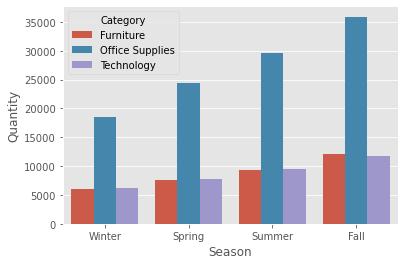

In [5]:
# two lines....
import seaborn as sns
sns.barplot(x="Season", y="Quantity", hue="Category", data=season_trend)

### Problem 3: Why did customers make returns?
- Your manager required you to give a brief report (**Plots + Interpretations**) on returned orders.

	1. How much profit did we lose due to returns each year?


	2. How many customer returned more than once? more than 5 times?


	3. Which regions are more likely to return orders?


	4. Which categories (sub-categories) of products are more likely to be returned?

- ***Hint:*** Merge the **Returns** dataframe with the **Orders** dataframe using `Order.ID`.

In [7]:
returns = pd.read_csv('../data/Returns.csv', index_col=0)
returns.columns = ['Order.ID', 'Region'] # rename columns of returns
returned_orders = orders.merge(returns, left_on='Order.ID', right_on='Order.ID') # merge orders and returns
returned_orders['Year'] = pd.DatetimeIndex(returned_orders['Order.Date']).year # new feature: Year

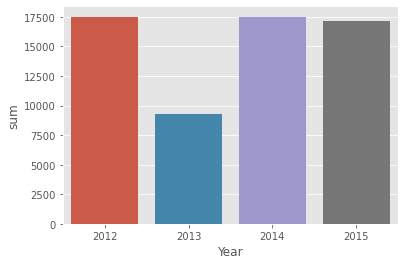

In [8]:
# How much profit did we lose due to returns each year?
# group all returned orders by year, and calculated the total amount of profit.
ret_orders = returned_orders.groupby(['Year']).agg({"Profit":['sum']})  # grouped by Year, calculated total Profit
ret_orders.columns = ret_orders.columns.droplevel(0) # removed 'Profit' from new column name
ret_orders.reset_index(inplace=True) # created a new column from the index
sns.barplot(x="Year", y="sum", data=ret_orders) # plot total Profit by Year

In [9]:
#Now lets compare how much was lost 
#Filter only products that had a loss
Profit_loss = returned_orders[['Year', 'Profit']]

Profit_loss['Profit'] = returned_orders[returned_orders['Profit'] < 0]['Profit']
Profit_loss.dropna()

Profit_Loss_table = Profit_loss.groupby(['Year']).agg({"Profit":['sum']})
Profit_Loss_table

<ipython-input-9-8d4bf8897078>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Profit_loss['Profit'] = returned_orders[returned_orders['Profit'] < 0]['Profit']


,Profit
,sum
Year,
2012,-5772.54
2013,-7713.03
2014,-7439.43
2015,-15907.60


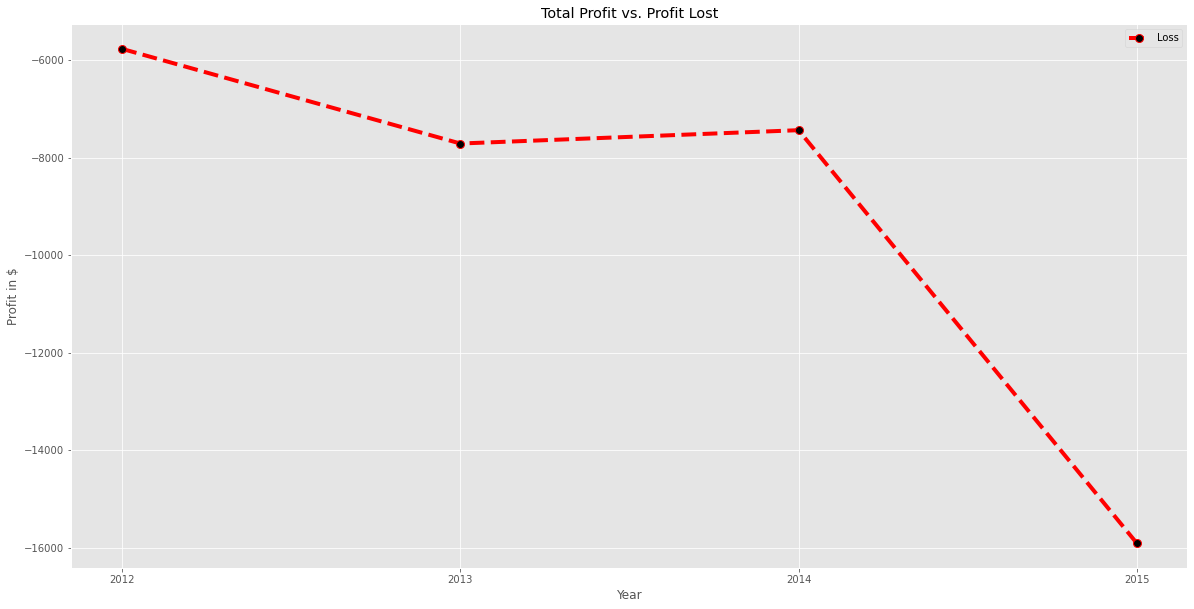

In [10]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
x = [2012, 2013, 2014, 2015]
plt.figure(figsize=(20,10))
# multiple line plot
plt.plot( x, 'Profit', data=Profit_Loss_table, marker='o', markerfacecolor='black', markersize=8, color='red', linewidth=4, linestyle = 'dashed', label = "Loss")
# plt.plot( x, 'Profit', data=Total_Profit, marker='s', markerfacecolor='black', markersize=8, color='blue', linewidth=4, linestyle = 'dashed', label = "Total Profit")
plt.xticks(x)
plt.xlabel('Year')
plt.ylabel('Profit in $') 
plt.title('Total Profit vs. Profit Lost')
plt.legend()

In [11]:
# 2. How many customer returned more than once? more than 5 times?
returned_orders_customer = returned_orders.groupby(['Customer.ID','Order.ID']).agg({"Order.ID":['count']})
returned_orders_customer = returned_orders_customer.reset_index()
print('Number of customers that returned more than once: ',returned_orders_customer[returned_orders_customer['Order.ID']['count']>1]['Customer.ID'].size)
print('Number of customers that returned more than 5 times: ',returned_orders_customer[returned_orders_customer['Order.ID']['count']>5]['Customer.ID'].size)

Number of customers that returned more than once:  551
Number of customers that returned more than 5 times:  41


In [12]:
# 3. Which regions are more likely to return orders?
returned_orders_regions = pd.DataFrame(returns.groupby(['Region']).size())
returned_orders_regions = (returned_orders_regions / returned_orders_regions[0].sum() * 100).round(2).sort_values([0], ascending=False)
returned_orders_regions.reset_index(inplace=True)
returned_orders_regions.columns = ['Region','Percentage']

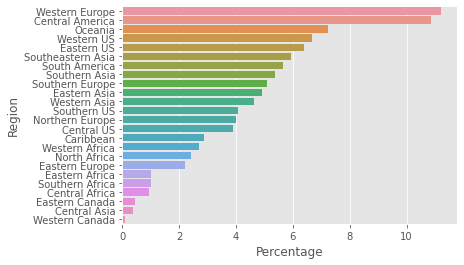

In [13]:
sns.barplot(x="Percentage", y="Region", data=returned_orders_regions, )

In [14]:
# 4. Which categories (sub-categories) of products are more likely to be returned?
returned_categories = pd.DataFrame(returned_orders.groupby(['Category','Sub.Category']).size())
returned_categories = (returned_categories / returned_categories[0].sum() * 100).round(2).sort_values([0], ascending=False)
returned_categories.reset_index(inplace=True)
returned_categories.columns = ['Category', 'Sub.Category', 'Percentage']

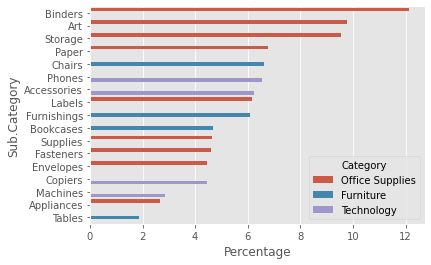

In [15]:
sns.barplot(x="Percentage", y="Sub.Category", hue="Category", data=returned_categories)